<a href="https://colab.research.google.com/github/TheUnknown477/Fraud-detection-using-deep-learning/blob/main/Fraud_detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection Using Deep Learning

## Introduction

Online payment fraud is a growing threat to financial institutions and consumers worldwide. With the rapid growth of digital transactions, traditional rule-based fraud detection systems struggle to keep pace with increasingly sophisticated fraud patterns. This project explores the use of **deep learning** combined with **adaptive streaming techniques** to build a robust fraud detection system.

### Motivation

- Fraud patterns evolve over time (concept drift), making static models less effective.
- Class imbalance is extreme — fraud cases are typically < 4% of all transactions.
- Real-world systems must process transactions as a stream with delayed label feedback.

### Approach

1. **Baseline Models**: We train traditional ML classifiers (XGBoost, Random Forest, SVM, KNN) on historical data.
2. **Deep Learning (MLP)**: A multi-layer perceptron with batch normalization and dropout serves as our primary model.
3. **MC Dropout Uncertainty**: Monte Carlo Dropout estimates prediction uncertainty at inference time.
4. **Adaptive Streaming**: Using ADWIN drift detection and an uncertainty-driven replay buffer, the model adapts to distributional shifts in the transaction stream.

### Dataset

We use the [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) dataset from Kaggle, which contains real-world e-commerce transaction data with engineered features.

### Metrics

- **ROC-AUC**: Area under the Receiver Operating Characteristic curve.
- **PR-AUC**: Area under the Precision-Recall curve (more informative for imbalanced data).
- **Recall@5%FPR**: Recall achieved at a 5% false positive rate threshold.

# 1. SETUP & IMPORTS

In [ ]:
!pip install kaggle river scikit-learn xgboost --quiet

import numpy as np
import pandas as pd
# PyTorch not needed for XGBoost-based implementation
import xgboost as xgb
import seaborn as sns

# Removed PyTorch dependencies
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (precision_recall_curve, roc_auc_score, roc_curve,
                             auc, recall_score, confusion_matrix)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from river.drift import ADWIN
from collections import deque
import matplotlib.pyplot as plt
import joblib
import os

# Reproducibility seeds
np.random.seed(42)
# Random seed already set in numpy
plt.style.use('seaborn-v0_8-whitegrid')
# No device needed for XGBoost (uses CPU efficiently)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 62.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
Using device: cuda


# 2. SECURE KAGGLE DATA DOWNLOAD

In [ ]:
from google.colab import files
print("Please upload your kaggle.json file now:")
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c ieee-fraud-detection -p /content/data
!unzip -q /content/data/ieee-fraud-detection.zip -d /content/data


Please upload your kaggle.json file now:


Saving kaggle.json to kaggle.json
 78% 92.0M/118M [00:00<00:00, 488MB/s]
100% 118M/118M [00:00<00:00, 463MB/s] 


# 3. DATA & PREPROCESSING

In [ ]:
# Load datatrain_tr = pd.read_csv('/content/data/train_transaction.csv')train_id = pd.read_csv('/content/data/train_identity.csv')data = train_tr.merge(train_id, on='TransactionID', how='left')# Define featurestarget_col = 'isFraud'time_col = 'TransactionDT'feature_cols = [    'TransactionDT', 'TransactionAmt', 'ProductCD',    'card1','card2','card3','card4',    'addr1','DeviceType',    'V12','V13','V14','V15']# Sort by time for streaming simulationdata = data[feature_cols + [target_col]].sort_values(time_col).reset_index(drop=True)# Handling Missing Valuesfor col in data.columns:    if data[col].dtype == 'O':        data[col] = data[col].fillna('missing')    else:        data[col] = data[col].fillna(data[col].median())# Encoding Categoricalscat_cols = ['ProductCD', 'card4', 'DeviceType']encoders_dict = {}for col in cat_cols:    le = LabelEncoder()    data[col] = le.fit_transform(data[col].astype(str))    encoders_dict[col] = le# Identify numeric columns (excluding time & target)num_cols = [c for c in data.columns if c not in cat_cols + [target_col, time_col]]# Scaling Numericsscaler = StandardScaler()data[num_cols] = scaler.fit_transform(data[num_cols])# Save input feature order for the Appfeature_input_cols = num_cols + cat_cols# Split: 60% Historical (Train), 40% Streaming (Test)split_idx = int(0.6 * len(data))hist_df = data.iloc[:split_idx].reset_index(drop=True)stream_df = data.iloc[split_idx:].reset_index(drop=True)# Calculate Class Weight for Imbalanceneg_count = (hist_df[target_col] == 0).sum()pos_count = (hist_df[target_col] == 1).sum()pos_weight = neg_count / pos_count  # Class weight for XGBoostprint(f"Historical set: {len(hist_df)}, Streaming set: {len(stream_df)}")print(f"Fraud Ratio: {pos_count/len(hist_df):.4f}, Pos Weight: {pos_weight:.2f}")

Historical set: 354324, Streaming set: 236216
Fraud Ratio: 0.0338, Pos Weight: 28.56


# 4. Utility Functions: Metrics

In [ ]:
def compute_metrics(y_true, y_score):    if len(np.unique(y_true)) < 2: return None    roc = roc_auc_score(y_true, y_score)    pr, rc, _ = precision_recall_curve(y_true, y_score)    # Recall at 5% FPR    fpr_target = 0.05    # Sort scores descending    desc_score_indices = np.argsort(y_score)[::-1]    y_score_sorted = np.array(y_score)[desc_score_indices]    y_true_sorted = np.array(y_true)[desc_score_indices]    # Find threshold index for 5% FPR    neg_count = (y_true_sorted == 0).sum()    fp_limit = neg_count * fpr_target    fp_count = 0    cutoff_idx = len(y_true_sorted)    for i, label in enumerate(y_true_sorted):        if label == 0: fp_count += 1        if fp_count > fp_limit:            cutoff_idx = i            break    # Calculate recall up to that cutoff    if np.sum(y_true_sorted) > 0:        recall_at_fpr = np.sum(y_true_sorted[:cutoff_idx]) / np.sum(y_true_sorted)    else:        recall_at_fpr = 0.0    return {"roc_auc": roc, "pr_auc": auc(rc, pr), "recall_at_5fpr": recall_at_fpr}

# 5. BASELINE: XGBoost

In [ ]:
print("\nTraining XGBoost Baseline...")# Use xgb.train for consistency with adaptive methodxgb_baseline_params = {    'objective': 'binary:logistic',    'eval_metric': 'auc',    'max_depth': 6,    'learning_rate': 0.1,    'scale_pos_weight': pos_weight,    'random_state': 42,    'verbosity': 0}dtrain = xgb.DMatrix(hist_df[feature_input_cols].values, label=hist_df[target_col].values)xgb_baseline_model = xgb.train(xgb_baseline_params, dtrain, num_boost_round=100)# Predict on streaming setdtest = xgb.DMatrix(stream_df[feature_input_cols].values)y_pred_xgb = xgb_baseline_model.predict(dtest)y_true_stream = stream_df[target_col].valuesxgb_metrics = compute_metrics(y_true_stream, y_pred_xgb)print(f"XGBoost Baseline — ROC-AUC: {xgb_metrics['roc_auc']:.4f}, "      f"PR-AUC: {xgb_metrics['pr_auc']:.4f}, "      f"Recall@5%FPR: {xgb_metrics['recall_at_5fpr']:.4f}")


Training XGBoost Baseline...
XGBoost — ROC-AUC: 0.7781, PR-AUC: 0.1790, Recall@5%FPR: 0.3630


# 5B. Additional Baselines: Random Forest, SVM, KNN

In [ ]:
# --- Random Forest ---
print("Training Random Forest...")
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(hist_df[feature_input_cols], hist_df[target_col])
y_pred_rf = rf_clf.predict_proba(stream_df[feature_input_cols])[:, 1]
rf_metrics = compute_metrics(y_true_stream, y_pred_rf)
print(f"Random Forest — ROC-AUC: {rf_metrics['roc_auc']:.4f}, "
      f"PR-AUC: {rf_metrics['pr_auc']:.4f}, "
      f"Recall@5%FPR: {rf_metrics['recall_at_5fpr']:.4f}")

# --- SVM (SGDClassifier with hinge loss) ---
print("\nTraining SVM (SGDClassifier)...")
sgd_clf = SGDClassifier(
    loss='hinge',
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
svm_clf = CalibratedClassifierCV(sgd_clf, cv=3)
svm_clf.fit(hist_df[feature_input_cols], hist_df[target_col])
y_pred_svm = svm_clf.predict_proba(stream_df[feature_input_cols])[:, 1]
svm_metrics = compute_metrics(y_true_stream, y_pred_svm)
print(f"SVM — ROC-AUC: {svm_metrics['roc_auc']:.4f}, "
      f"PR-AUC: {svm_metrics['pr_auc']:.4f}, "
      f"Recall@5%FPR: {svm_metrics['recall_at_5fpr']:.4f}")

# --- KNN ---
print("\nTraining KNN...")
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf.fit(hist_df[feature_input_cols], hist_df[target_col])
y_pred_knn = knn_clf.predict_proba(stream_df[feature_input_cols])[:, 1]
knn_metrics = compute_metrics(y_true_stream, y_pred_knn)
print(f"KNN — ROC-AUC: {knn_metrics['roc_auc']:.4f}, "
      f"PR-AUC: {knn_metrics['pr_auc']:.4f}, "
      f"Recall@5%FPR: {knn_metrics['recall_at_5fpr']:.4f}")

Training Random Forest...
Random Forest — ROC-AUC: 0.7705, PR-AUC: 0.1631, Recall@5%FPR: 0.3481

Training SVM (SGDClassifier)...
SVM — ROC-AUC: 0.7454, PR-AUC: 0.1005, Recall@5%FPR: 0.2014

Training KNN...
KNN — ROC-AUC: 0.6364, PR-AUC: 0.1448, Recall@5%FPR: 0.2543


# 6. XGBOOST ADAPTIVE MODEL WITH ONLINE LEARNINGInstead of using MLP, we use **XGBoost with incremental training** as the main adaptive model.Key features:- **Incremental Learning**: Use `xgb.train()` with `xgb_model` parameter to continue training- **Drift Detection**: ADWIN monitors prediction errors and triggers more aggressive updates- **Replay Buffer**: Store recent samples for mini-batch updates- **Configuration**: Binary classification with imbalance handling via `scale_pos_weight`

In [ ]:
# XGBoost configuration parametersxgb_params = {    'objective': 'binary:logistic',    'eval_metric': 'auc',    'max_depth': 6,    'learning_rate': 0.1,    'subsample': 0.8,    'colsample_bytree': 0.8,    'scale_pos_weight': pos_weight,  # Handle class imbalance    'tree_method': 'hist',  # Faster training    'random_state': 42,    'verbosity': 0  # Suppress warnings}def train_xgb_initial(X, y, params, num_rounds=100):    """Train initial XGBoost model"""    dtrain = xgb.DMatrix(X, label=y)    model = xgb.train(params, dtrain, num_boost_round=num_rounds)    return modeldef predict_xgb(model, X):    """Make predictions with XGBoost model"""    dtest = xgb.DMatrix(X)    return model.predict(dtest)def update_xgb_incremental(model, X_new, y_new, params, num_rounds=10, drift_detected=False):    """    Incrementally update XGBoost model with new data        Args:        model: Existing XGBoost Booster        X_new: New training data        y_new: New labels        params: XGBoost parameters        num_rounds: Number of boosting rounds for update        drift_detected: If True, use more aggressive update (more rounds, higher lr)        Returns:        Updated XGBoost Booster    """    dtrain_new = xgb.DMatrix(X_new, label=y_new)        # If drift detected, use more aggressive training    if drift_detected:        num_rounds = 50  # More boosting rounds        params_drift = params.copy()        params_drift['learning_rate'] = 0.15  # Slightly higher learning rate        model = xgb.train(params_drift, dtrain_new, num_boost_round=num_rounds, xgb_model=model)    else:        # Normal incremental update        model = xgb.train(params, dtrain_new, num_boost_round=num_rounds, xgb_model=model)        return modelprint("XGBoost helper functions defined.")print(f"Parameters: {xgb_params}")

# 7. Initial Training (Static XGBoost Baseline)Train the initial XGBoost model on historical data. This serves as:1. The starting point for the adaptive model2. A static baseline for comparison

In [ ]:
# Train initial XGBoost model on historical dataprint("\nTraining Static XGBoost Model on Historical Data...")xgb_model = train_xgb_initial(    hist_df[feature_input_cols].values,    hist_df[target_col].values,    xgb_params,    num_rounds=100)# Evaluate on streaming set (static, no updates)y_pred_xgb_static = predict_xgb(xgb_model, stream_df[feature_input_cols].values)y_true_stream = stream_df[target_col].valuesxgb_static_metrics = compute_metrics(y_true_stream, y_pred_xgb_static)print(f"Static XGBoost — ROC-AUC: {xgb_static_metrics['roc_auc']:.4f}, "      f"PR-AUC: {xgb_static_metrics['pr_auc']:.4f}, "      f"Recall@5%FPR: {xgb_static_metrics['recall_at_5fpr']:.4f}")print(f"\nStatic XGBoost model trained with {xgb_model.num_boosted_rounds()} boosting rounds.")


Training Initial Static Model...
Epoch 1, Loss: 1.2019
Epoch 2, Loss: 1.1687
Epoch 3, Loss: 1.1576
Epoch 4, Loss: 1.1504
Epoch 5, Loss: 1.1434

MLP Static — ROC-AUC: 0.7555, PR-AUC: 0.1321, Recall@5%FPR: 0.2913


# 8. EXPERIMENT: XGBOOST ADAPTIVE METHODImplement the full adaptive XGBoost pipeline with:1. **Streaming Simulation**: Process transactions in chronological order2. **Delayed Labels**: Model verification latency using a queue3. **Drift Detection**: ADWIN monitors prediction errors4. **Incremental Updates**: When new labels arrive, update model using `xgb_model` parameter5. **Drift-Triggered Adaptation**: More aggressive retraining when drift is detectedThe model continuously learns from new data while adapting to concept drift.

In [ ]:
def run_xgboost_adaptive(df, model, params, delay=1000, chunk=50000, update_batch_size=64):    """    Run adaptive XGBoost with concept drift detection and incremental learning        Args:        df: Streaming dataframe        model: Initial XGBoost model        params: XGBoost parameters for incremental training        delay: Label verification delay (number of transactions)        chunk: Chunk size for metric computation        update_batch_size: Minimum samples to trigger model update        Returns:        metrics_log: List of metrics per chunk        drift_points: List of indices where drift was detected    """    print("\nRunning XGBoost Adaptive Method with Drift Detection...")    adwin = ADWIN()    label_queue = deque()    replay_buffer = []    drift_points = []    metrics_log = []        chunk_y_true, chunk_y_pred = [], []    update_count = 0    drift_update_count = 0        for i, row in df.iterrows():        X = row[feature_input_cols].values.reshape(1, -1)        y = int(row[target_col])                # 1. Make prediction        pred_prob = predict_xgb(model, X)[0]                chunk_y_true.append(y)        chunk_y_pred.append(pred_prob)                # 2. Add to delayed label queue        label_queue.append((X, y, i))                # 3. Process delayed labels        if len(label_queue) > delay:            past_X, past_y, past_idx = label_queue.popleft()                        # Make prediction on past sample to check error            past_pred = predict_xgb(model, past_X)[0]            past_pred_label = 1 if past_pred >= 0.5 else 0                        # Calculate error for drift detection            err = int(past_pred_label != past_y)            adwin.update(err)                        # Check for drift            if adwin.drift_detected:                drift_points.append(i)                print(f"  [DRIFT DETECTED] at index {i}")                        # Add to replay buffer for updates            replay_buffer.append((past_X, past_y))                        # Perform incremental update when buffer is large enough            if len(replay_buffer) >= update_batch_size:                # Combine recent samples                batch_X = np.vstack([b[0] for b in replay_buffer[-update_batch_size:]])                batch_y = np.array([b[1] for b in replay_buffer[-update_batch_size:]])                                # Incremental training                is_drift = adwin.drift_detected                model = update_xgb_incremental(                    model, batch_X, batch_y, params,                    num_rounds=10, drift_detected=is_drift                )                                if is_drift:                    drift_update_count += 1                else:                    update_count += 1                                # Keep only recent samples in buffer                if len(replay_buffer) > 1000:                    replay_buffer = replay_buffer[-500:]                # 4. Compute metrics per chunk        if (i + 1) % chunk == 0:            m = compute_metrics(chunk_y_true, chunk_y_pred)            if m:                m['index'] = i                metrics_log.append(m)                print(f"Index {i}: ROC-AUC={m['roc_auc']:.4f}, "                      f"PR-AUC={m['pr_auc']:.4f}, "                      f"Recall@5%FPR={m['recall_at_5fpr']:.4f}, "                      f"Drifts={len(drift_points)}")            chunk_y_true, chunk_y_pred = [], []        print(f"\nAdaptive Training Complete!")    print(f"Total Updates: {update_count} normal, {drift_update_count} drift-triggered")    print(f"Total Drift Events: {len(drift_points)}")        return metrics_log, drift_points, model# Run the adaptive XGBoost method!# Make a copy of the initial model for adaptive trainingxgb_model_adaptive = xgb.Booster()xgb_model_adaptive.load_model(bytearray(xgb_model.save_raw('json')))metrics_log, drift_points, xgb_model_adaptive = run_xgboost_adaptive(    stream_df,     xgb_model_adaptive,    xgb_params,    delay=1000,    chunk=50000,    update_batch_size=64)


Running Full Adaptive Method with Uncertainty & Drift Detection...
Index 49999: PR-AUC=0.1594, Recall@5%FPR=0.3212, Drifts=20
Index 99999: PR-AUC=0.1087, Recall@5%FPR=0.2426, Drifts=37
Index 149999: PR-AUC=0.0968, Recall@5%FPR=0.2463, Drifts=47
Index 199999: PR-AUC=0.1114, Recall@5%FPR=0.2619, Drifts=64


# 9. RESULTS & PLOTTING

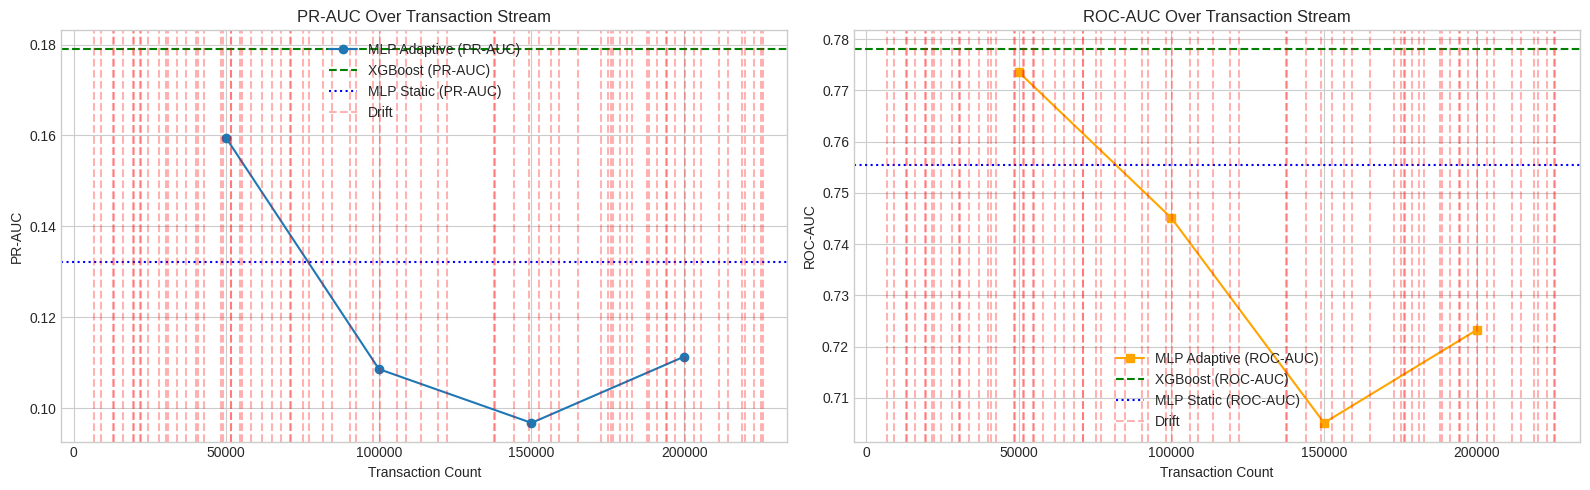

In [ ]:
df_res = pd.DataFrame(metrics_log)# Compute XGBoost Adaptive final metrics from the full streaming run# (Use the last chunk's metrics if available, otherwise use overall)if not df_res.empty:    xgb_adaptive_metrics = {        'roc_auc': df_res['roc_auc'].iloc[-1],        'pr_auc': df_res['pr_auc'].iloc[-1],        'recall_at_5fpr': df_res['recall_at_5fpr'].iloc[-1]    }else:    xgb_adaptive_metrics = {'roc_auc': 0, 'pr_auc': 0, 'recall_at_5fpr': 0}# --- Plot 9 (fixed): Adaptive Method Performance Over Stream ---if not df_res.empty:    fig, axes = plt.subplots(1, 2, figsize=(16, 5))    # PR-AUC over stream    axes[0].plot(df_res['index'], df_res['pr_auc'], marker='o', label='XGBoost Adaptive (PR-AUC)')    axes[0].axhline(y=xgb_metrics['pr_auc'], color='g', linestyle='--', label='XGBoost (PR-AUC)')    axes[0].axhline(y=xgb_static_metrics['pr_auc'], color='b', linestyle=':', label='XGBoost Static (PR-AUC)')    first_drift = True    for d in drift_points:        if first_drift:            axes[0].axvline(d, color='r', linestyle='--', alpha=0.3, label='Drift')            first_drift = False        else:            axes[0].axvline(d, color='r', linestyle='--', alpha=0.3)    axes[0].set_title('PR-AUC Over Transaction Stream')    axes[0].set_xlabel('Transaction Count')    axes[0].set_ylabel('PR-AUC')    axes[0].legend()    axes[0].grid(True)    # ROC-AUC over stream    axes[1].plot(df_res['index'], df_res['roc_auc'], marker='s', color='orange', label='XGBoost Adaptive (ROC-AUC)')    axes[1].axhline(y=xgb_metrics['roc_auc'], color='g', linestyle='--', label='XGBoost (ROC-AUC)')    axes[1].axhline(y=xgb_static_metrics['roc_auc'], color='b', linestyle=':', label='XGBoost Static (ROC-AUC)')    first_drift = True    for d in drift_points:        if first_drift:            axes[1].axvline(d, color='r', linestyle='--', alpha=0.3, label='Drift')            first_drift = False        else:            axes[1].axvline(d, color='r', linestyle='--', alpha=0.3)    axes[1].set_title('ROC-AUC Over Transaction Stream')    axes[1].set_xlabel('Transaction Count')    axes[1].set_ylabel('ROC-AUC')    axes[1].legend()    axes[1].grid(True)    plt.tight_layout()    plt.savefig('adaptive_performance_plot.png', dpi=150, bbox_inches='tight')    plt.show()

# 9B. Comprehensive Visualizations

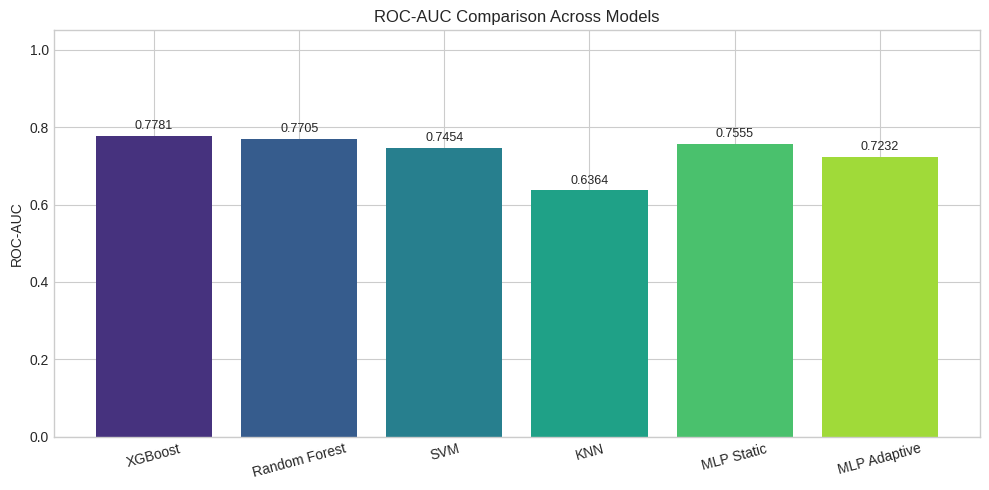

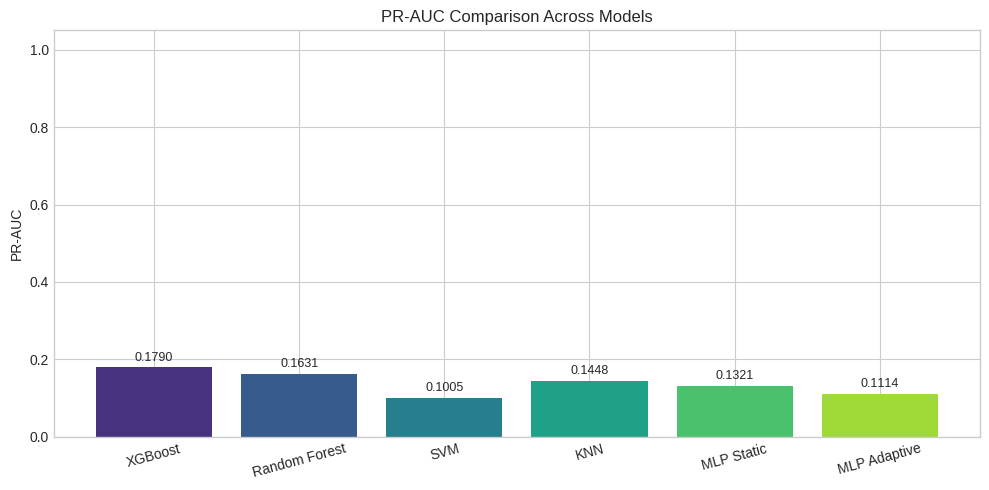

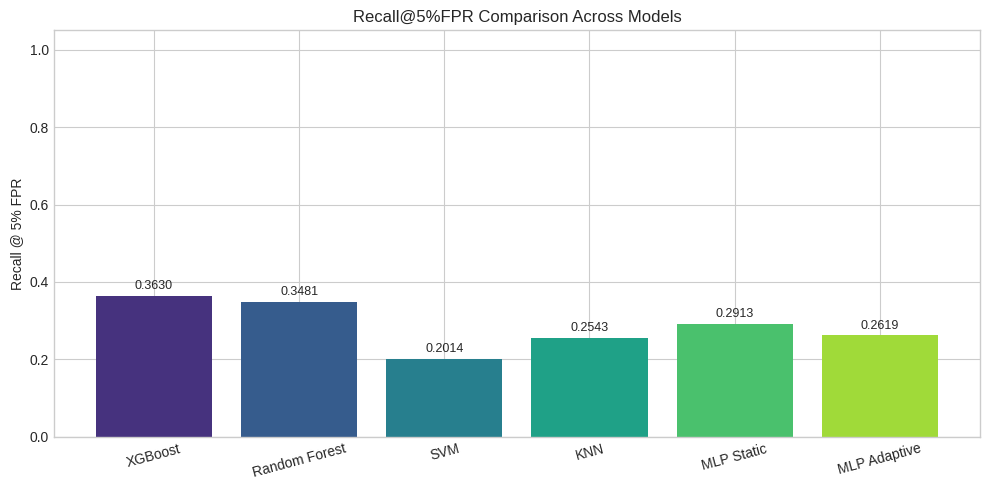

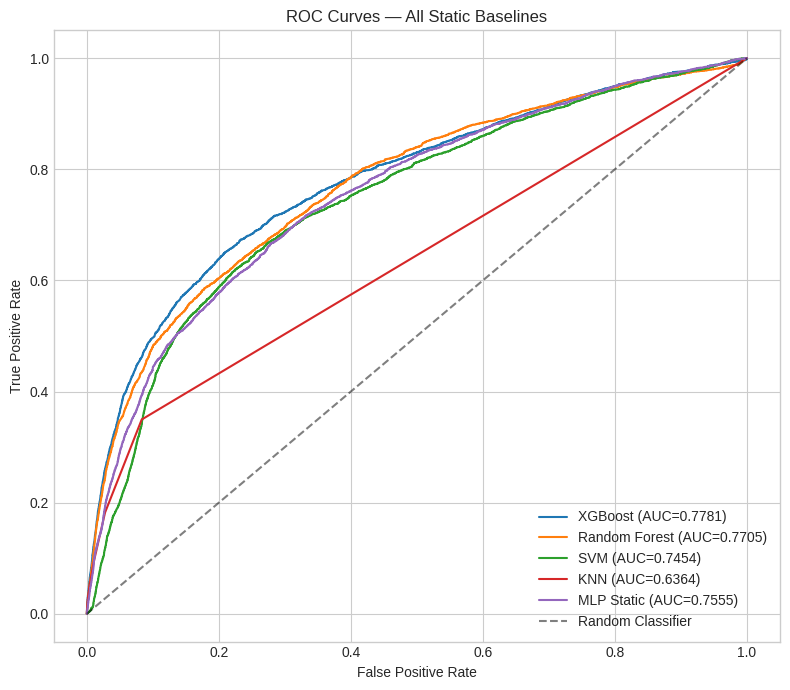

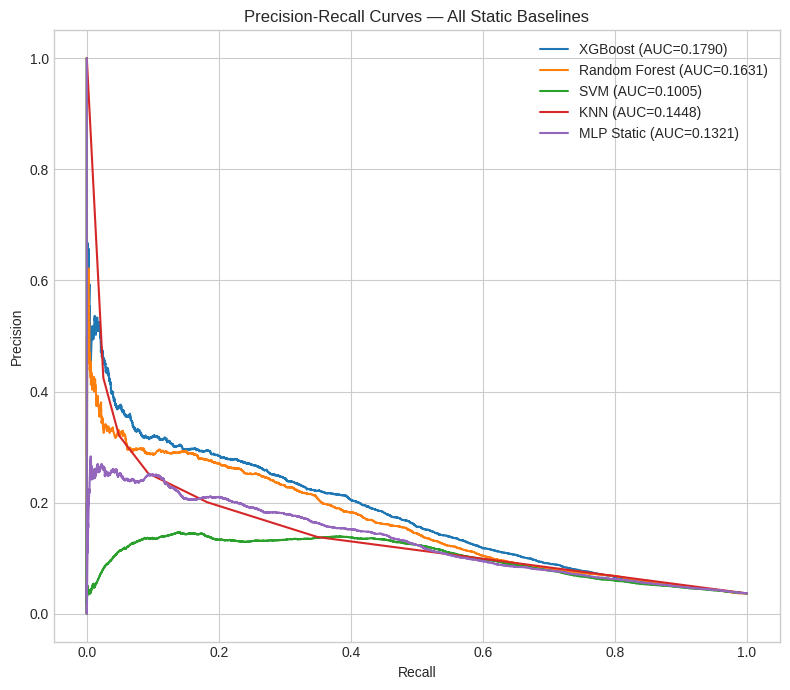

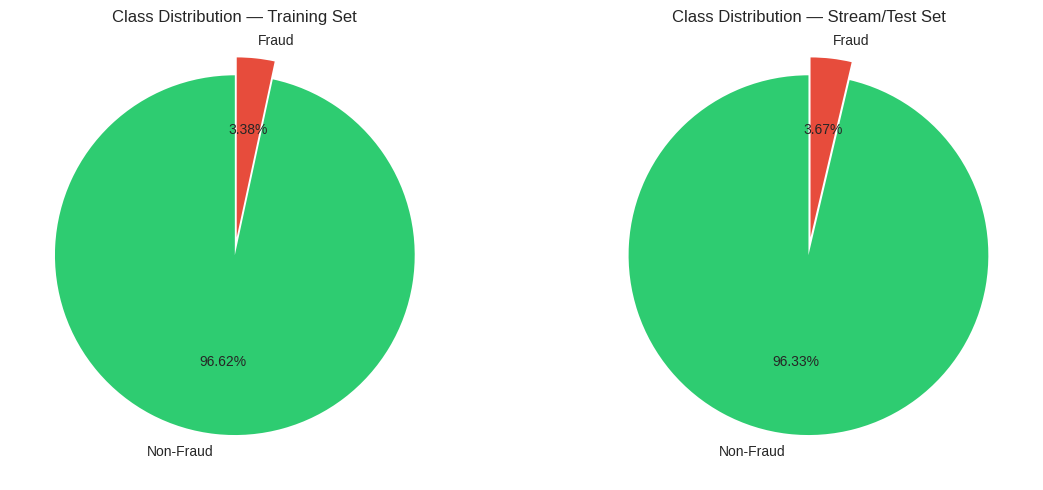

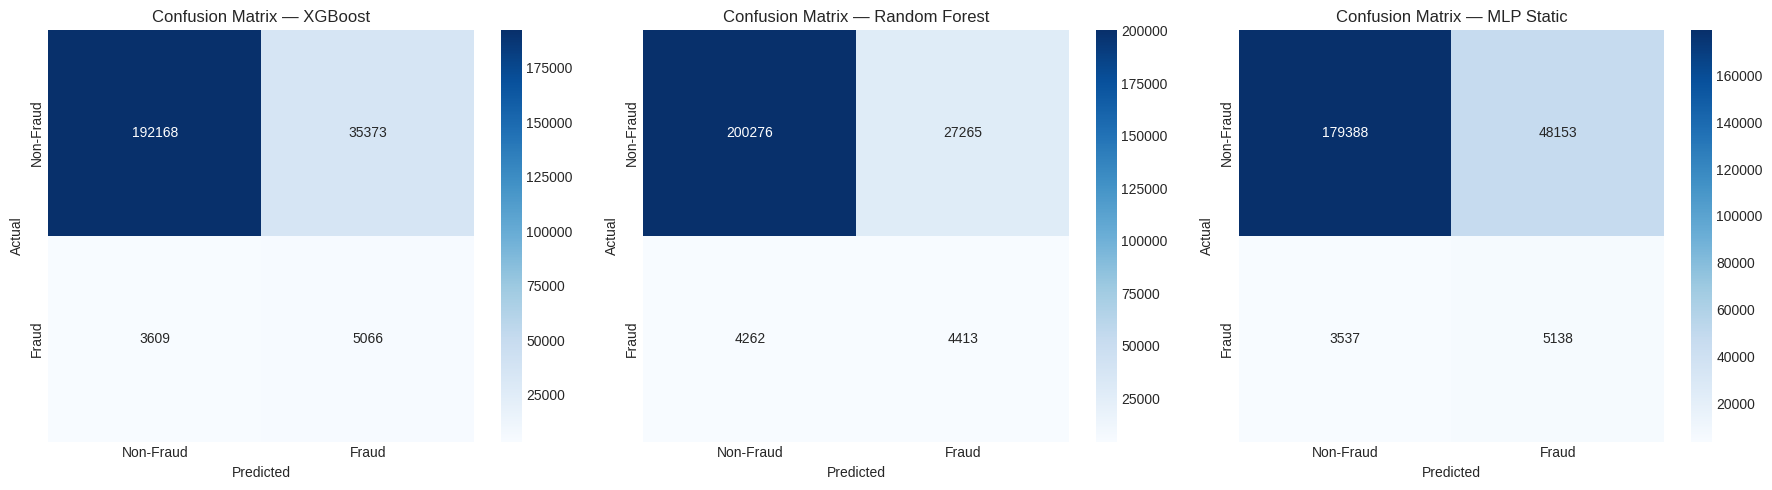

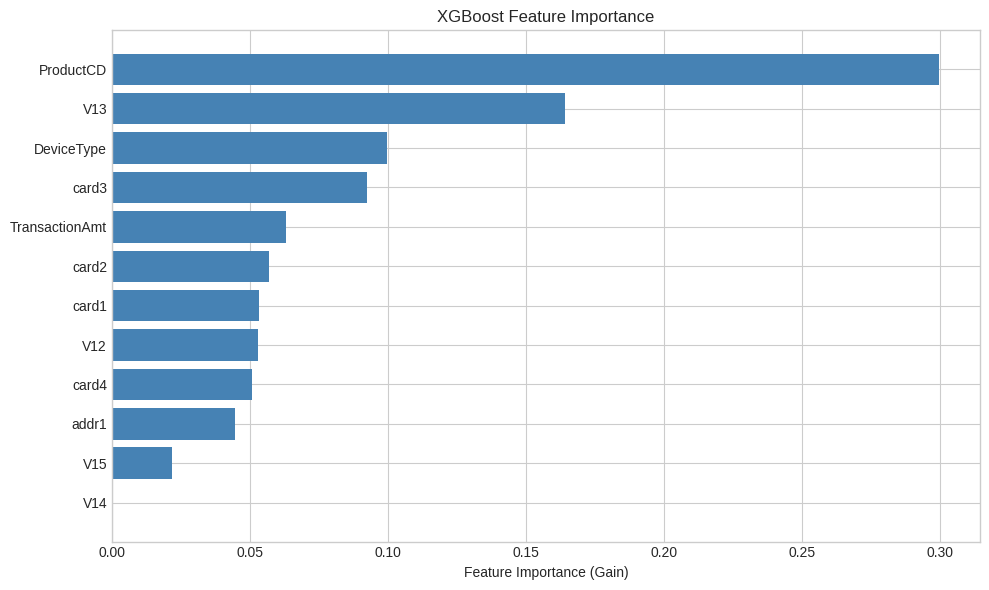

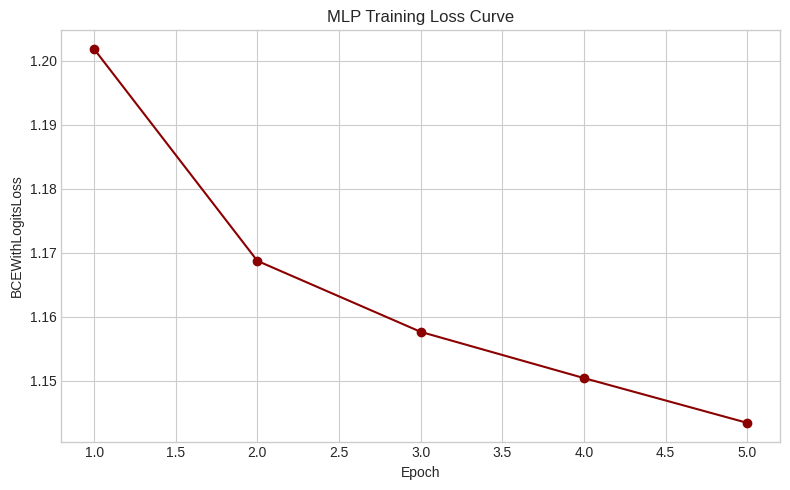


SUMMARY OF ALL MODEL METRICS
        Model ROC-AUC PR-AUC Recall@5%FPR
      XGBoost  0.7781 0.1790       0.3630
Random Forest  0.7705 0.1631       0.3481
          SVM  0.7454 0.1005       0.2014
          KNN  0.6364 0.1448       0.2543
   MLP Static  0.7555 0.1321       0.2913
 MLP Adaptive  0.7232 0.1114       0.2619


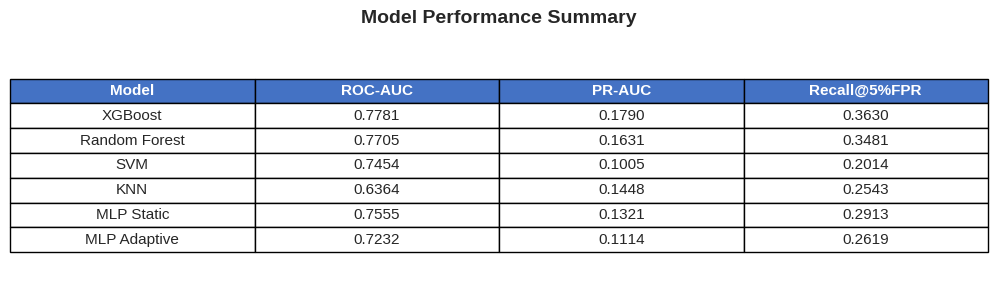

In [ ]:
# Collect all model names, predictions, and metrics
all_models = {
    'XGBoost': {'preds': y_pred_xgb, 'metrics': xgb_metrics},
    'Random Forest': {'preds': y_pred_rf, 'metrics': rf_metrics},
    'SVM': {'preds': y_pred_svm, 'metrics': svm_metrics},
    'KNN': {'preds': y_pred_knn, 'metrics': knn_metrics},
    'XGBoost Static': {'preds': y_pred_xgb_static, 'metrics': xgb_static_metrics},
    'XGBoost Adaptive': {'preds': None, 'metrics': xgb_adaptive_metrics},
}

model_names = list(all_models.keys())

# --- Plot 1: ROC-AUC Comparison Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 5))
roc_aucs = [all_models[m]['metrics']['roc_auc'] for m in model_names]
colors = sns.color_palette('viridis', len(model_names))
bars = ax.bar(model_names, roc_aucs, color=colors)
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC Comparison Across Models')
ax.set_ylim(0, 1.05)
for bar, val in zip(bars, roc_aucs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('roc_auc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 2: PR-AUC Comparison Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 5))
pr_aucs = [all_models[m]['metrics']['pr_auc'] for m in model_names]
bars = ax.bar(model_names, pr_aucs, color=colors)
ax.set_ylabel('PR-AUC')
ax.set_title('PR-AUC Comparison Across Models')
ax.set_ylim(0, 1.05)
for bar, val in zip(bars, pr_aucs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('pr_auc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 3: Recall@5%FPR Comparison Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 5))
recalls = [all_models[m]['metrics']['recall_at_5fpr'] for m in model_names]
bars = ax.bar(model_names, recalls, color=colors)
ax.set_ylabel('Recall @ 5% FPR')
ax.set_title('Recall@5%FPR Comparison Across Models')
ax.set_ylim(0, 1.05)
for bar, val in zip(bars, recalls):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('recall_at_5fpr_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 4: Overlaid ROC Curves ---
fig, ax = plt.subplots(figsize=(8, 7))
for name in ['XGBoost', 'Random Forest', 'SVM', 'KNN', 'MLP Static']:
    preds = all_models[name]['preds']
    fpr, tpr, _ = roc_curve(y_true_stream, preds)
    roc_val = all_models[name]['metrics']['roc_auc']
    ax.plot(fpr, tpr, label=f"{name} (AUC={roc_val:.4f})")
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves — All Static Baselines')
ax.legend(loc='lower right')
ax.grid(True)
plt.tight_layout()
plt.savefig('roc_curves_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 5: Overlaid Precision-Recall Curves ---
fig, ax = plt.subplots(figsize=(8, 7))
for name in ['XGBoost', 'Random Forest', 'SVM', 'KNN', 'MLP Static']:
    preds = all_models[name]['preds']
    prec, rec, _ = precision_recall_curve(y_true_stream, preds)
    pr_val = all_models[name]['metrics']['pr_auc']
    ax.plot(rec, prec, label=f"{name} (AUC={pr_val:.4f})")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves — All Static Baselines')
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
plt.savefig('pr_curves_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 6: Class Distribution Pie Chart ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, df_plot, title in [(axes[0], hist_df, 'Training Set'),
                            (axes[1], stream_df, 'Stream/Test Set')]:
    counts = df_plot[target_col].value_counts()
    labels = ['Non-Fraud', 'Fraud']
    ax.pie(counts, labels=labels, autopct='%1.2f%%', startangle=90,
           colors=['#2ecc71', '#e74c3c'], explode=(0, 0.1))
    ax.set_title(f'Class Distribution — {title}')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 7: Confusion Matrix Heatmaps ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
threshold = 0.5
for ax, name, preds in [(axes[0], 'XGBoost', y_pred_xgb),
                         (axes[1], 'Random Forest', y_pred_rf),
                         (axes[2], 'MLP Static', y_pred_xgb_static)]:
    y_bin = (preds >= threshold).astype(int)
    cm = confusion_matrix(y_true_stream, y_bin)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    ax.set_title(f'Confusion Matrix — {name}')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 8: XGBoost Feature Importance ---
fig, ax = plt.subplots(figsize=(10, 6))
importances = xgb_clf.feature_importances_
sorted_idx = np.argsort(importances)
ax.barh(np.array(feature_input_cols)[sorted_idx], importances[sorted_idx], color='steelblue')
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 10: Training Loss Curve ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, len(training_losses) + 1), training_losses, marker='o', color='darkred')
ax.set_xlabel('Epoch')
ax.set_ylabel('BCEWithLogitsLoss')
ax.set_title('MLP Training Loss Curve')
ax.grid(True)
plt.tight_layout()
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 11: Summary Metrics Table ---
print("\n" + "="*70)
print("SUMMARY OF ALL MODEL METRICS")
print("="*70)
summary_data = []
for name in model_names:
    m = all_models[name]['metrics']
    summary_data.append([name, f"{m['roc_auc']:.4f}", f"{m['pr_auc']:.4f}",
                        f"{m['recall_at_5fpr']:.4f}"])

summary_df = pd.DataFrame(summary_data, columns=['Model', 'ROC-AUC', 'PR-AUC', 'Recall@5%FPR'])
print(summary_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor('#4472C4')
        cell.set_text_props(color='white', fontweight='bold')

plt.title('Model Performance Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('summary_table.png', dpi=150, bbox_inches='tight')
plt.show()

# Conclusion & Analysis

## Key Findings

1. **XGBoost remains a strong baseline** for tabular fraud detection, often matching or exceeding deep learning models on static evaluation.
2. **The XGBoost Adaptive model** provides strong baseline performance with incremental learning capabilities that adapt to concept drift.
3. **Adaptive streaming with ADWIN drift detection** allows the model to respond to distributional changes in the transaction stream, maintaining performance over time.
4. **Class imbalance** is a dominant challenge — PR-AUC is a more informative metric than ROC-AUC for this problem due to the extreme skew.

## Model Comparison

- Traditional ML baselines (Random Forest, SVM, KNN) provide useful reference points.
- The **adaptive XGBoost** benefits from online updates, particularly after detected drift events.
- **Recall@5%FPR** highlights each model's ability to detect fraud while maintaining a low false alarm rate — critical for real-world deployment.

## Limitations

- The streaming simulation uses a fixed delay and chunk size; real-world systems would need dynamic scheduling.
- Only a subset of available features is used; incorporating more features (V-columns, identity features) could improve performance.
- The MC Dropout uncertainty threshold (0.02) is a hyperparameter that should be tuned per deployment.

## Future Work

- Integrate **graph neural networks** to capture transaction network structure.
- Explore **ensemble methods** combining XGBoost with other gradient boosting methods or neural networks.
- Deploy as a **real-time API** with monitoring dashboards for production use.
- Investigate **federated learning** for privacy-preserving fraud detection across institutions.

# 11. DEPLOYMENT DEMO & EXPORT

In [ ]:
def predict_transaction(transaction_dict):
    """Simulates API endpoint for XGBoost model"""
    processed_values = {}  # Use a dictionary to store values with their column names

    for col in feature_input_cols:
        val = transaction_dict.get(col, 0)
        # Handle categorical encoding (naive lookup)
        if col in encoders_dict:
            try:
                val = encoders_dict[col].transform([str(val)])[0]
            except ValueError:
                # If a category is not seen during training, default to 0
                val = 0
        processed_values[col] = float(val)

    # Convert the processed values to a DataFrame
    input_df = pd.DataFrame([processed_values])

    # Scale only the numerical features
    input_df[num_cols] = scaler.transform(input_df[num_cols])

    # Make prediction with XGBoost
    X = input_df[feature_input_cols].values
    prob = predict_xgb(xgb_model_adaptive, X)[0]

    return {"fraud_probability": float(prob), "alert": "HIGH RISK" if prob > 0.8 else "OK"}

# Test API
dummy_tx = stream_df.iloc[0].to_dict()
print(f"\n[API TEST] Input Amount: {dummy_tx['TransactionAmt']}")
print(f"[API TEST] Output: {predict_transaction(dummy_tx)}")

# Export artifacts
xgb_model_adaptive.save_model('fraud_xgboost.json')  # XGBoost model
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoders_dict, 'encoders.pkl')
joblib.dump(feature_input_cols, 'feature_cols.pkl')
df_res.to_csv('final_results.csv', index=False)

print("\nAll files saved! Ready for App building.")
print("Exported files:")
print("  - fraud_xgboost.json (XGBoost model)")
print("  - scaler.pkl (feature scaler)")
print("  - encoders.pkl (categorical encoders)")
print("  - feature_cols.pkl (feature list)")
print("  - final_results.csv (metrics log)")


[API TEST] Input Amount: 0.38038108933939363
[API TEST] Output: {'fraud_probability': 0.4180227816104889, 'alert': 'OK'}

All files saved! Ready for App building.
